In [16]:
import pandas as pd
from Functions import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('train_clean.csv')
df.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geo_cod
0,0,15674932,Okwudilichukwu,668,France,1,33.0,3,0.0,2,1.0,0.0,181449.97,0,0
1,1,15749177,Okwudiliolisa,627,France,1,33.0,1,0.0,2,1.0,1.0,49503.50,0,0
2,2,15694510,Hsueh,678,France,1,40.0,10,0.0,2,1.0,0.0,184866.69,0,0


## Modelado

### Feature Engineering

In [5]:
dummies = pd.get_dummies(df['Geography'], dtype=int)
dummies.head()

,France,Germany,Spain
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,0,1


In [6]:
#NORMALIZACION
from sklearn.preprocessing import StandardScaler

#LISTA DE VARIABLES A NORMALIZAR
vars = ['Age','Balance']#'CreditScore',

#INSTANCIA DEL MODELO Y TRANSOFRMACION
std_vars = StandardScaler().fit_transform(df[vars])

#SE CREA DATAFRAME COMPLEMETARIO
std_vars = pd.DataFrame(std_vars, columns=vars)
std_vars.head(3)

,Age,Balance
0,-0.578074,-0.883163
1,-0.578074,-0.883163
2,0.211354,-0.883163


In [7]:
#SELECCION DE VARIABLES
vars = ['NumOfProducts','IsActiveMember','Gender']

#VARIABLES PREDICTIVAS
x = pd.concat([df[vars],
                std_vars,
                dummies], axis=1)

#VARIABLE OBJETIVO
y = df.Exited

### UnderSample

In [12]:
#DISTRIBUCION DE LAS CLASES EN Y
print(f'Cantidad de observaciones con clase 0: {sum(y==0)}')
print(f'Cantidad de observaciones con clase 1: {sum(y==1)}')

Cantidad de observaciones con clase 0: 130113
Cantidad de observaciones con clase 1: 34921


In [17]:
#IMPORTACION DE LIBRERIA
from imblearn.under_sampling import RandomUnderSampler

#PORCENTAJE DE REDUCCION VARIABLE MAYORITARIA
perc_reduce = int(sum(y==0)*0.6)

#SET HIPERPARAMETRO
sampling_strategy = {0:perc_reduce, 1:sum(y==1)}

#INSTANCIA ,ENTRAMIENTO Y TRANSFORMACION DEL MODELO
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
x_under, y_under = rus.fit_resample(x, y)

#RESULTADO
print(f'Cantidad de observaciones con clase 0: {sum(y_under==0)}')
print(f'Cantidad de observaciones con clase 1: {sum(y_under==1)}')


Cantidad de observaciones con clase 0: 78067
Cantidad de observaciones con clase 1: 34921


### OverSample

In [18]:
#IMPORTACION DE LIBRERIA
from imblearn.over_sampling import SMOTE

#PORCENTAJE DE REDUCCION VARIABLE MAYORITARIA
perc_increase = int(sum(y==0)*0.5)

#SET HIPERPARAMETRO
sampling_strategy = {0:sum(y==0), 1:perc_increase}

#INSTANCIA ,ENTRAMIENTO Y TRANSFORMACION DEL MODELO
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
x_over, y_over = smote.fit_resample(x, y)

#RESULTADO
print(f'Cantidad de observaciones con clase 0: {sum(y_over==0)}')
print(f'Cantidad de observaciones con clase 1: {sum(y_over==1)}')

Cantidad de observaciones con clase 0: 130113
Cantidad de observaciones con clase 1: 65056


### SVC - Entrenamiento y validacion simple del modelo

In [22]:
from sklearn.svm import SVC


#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = SVC(kernel='poly', degree=3, C=0.5, probability=True, class_weight='balanced')
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8007


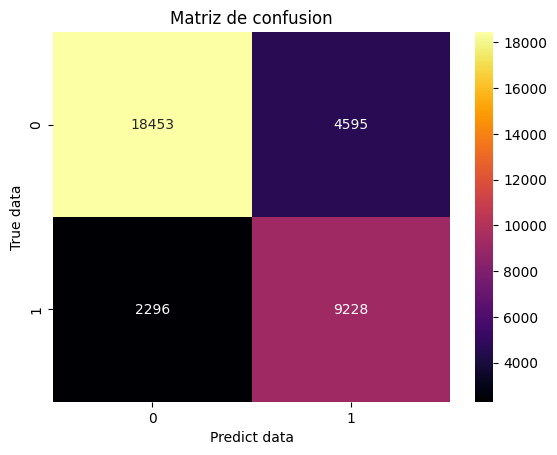

In [23]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [24]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84     23048
           1       0.67      0.80      0.73     11524

    accuracy                           0.80     34572
   macro avg       0.78      0.80      0.79     34572
weighted avg       0.82      0.80      0.80     34572



In [25]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8738


### KNN - Entrenamiento y validacion simple del modelo

In [26]:
#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, stratify=y_under,random_state=42)

#IMPORTACION DE LIBRERIA
from sklearn.neighbors import KNeighborsClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = KNeighborsClassifier(n_neighbors=35)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8292


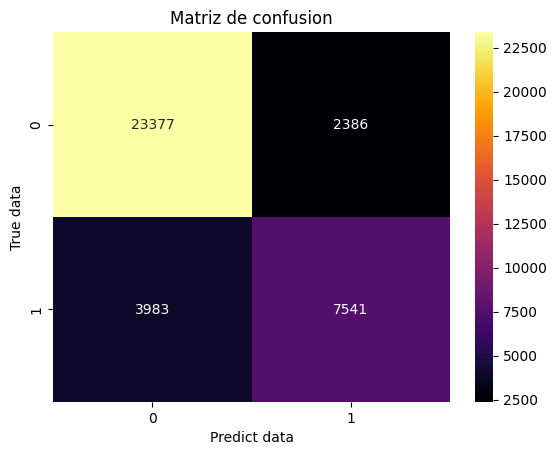

In [27]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [28]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     25763
           1       0.76      0.65      0.70     11524

    accuracy                           0.83     37287
   macro avg       0.81      0.78      0.79     37287
weighted avg       0.83      0.83      0.83     37287



In [29]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8767


In [30]:
#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.33, stratify=y_over,random_state=42)

#IMPORTACION DE LIBRERIA
from sklearn.neighbors import KNeighborsClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = KNeighborsClassifier(n_neighbors=35)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8265


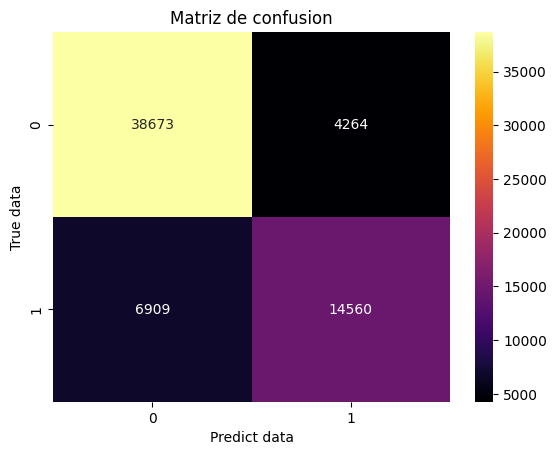

In [31]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [32]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87     42937
           1       0.77      0.68      0.72     21469

    accuracy                           0.83     64406
   macro avg       0.81      0.79      0.80     64406
weighted avg       0.82      0.83      0.82     64406



In [33]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8869


### Random Forest - Entrenamiento y validacion simple del modelo

In [143]:
#IMPOTRACION DE MODELO PARA TEST DE PARAMETROS
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

grid_param = param_grid = {
    'criterion' : ['entropy'],
    'n_estimators': [200, 300],
    'max_depth': [10, 18, 20],
    #'max_features' : [0.5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False],
    'random_state': [42]
}

#SE ENTRENA MODELO UTILIZANDO GRIDSEARCH
model = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=param_grid,
                     cv=3, n_jobs=-1,
                     scoring='accuracy')

model.fit(X_train, y_train)

model.best_score_

In [34]:
#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, stratify=y_under,random_state=42)

#IMPORTACION DE LIBRERIA
from sklearn.ensemble import RandomForestClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier( bootstrap=True,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_leaf=4,
                                min_samples_split=5,
                                n_estimators=200,
                                random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8314


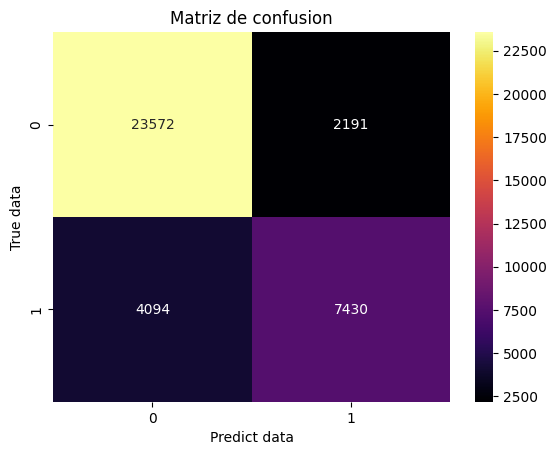

In [35]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [36]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     25763
           1       0.77      0.64      0.70     11524

    accuracy                           0.83     37287
   macro avg       0.81      0.78      0.79     37287
weighted avg       0.83      0.83      0.83     37287



In [37]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8835


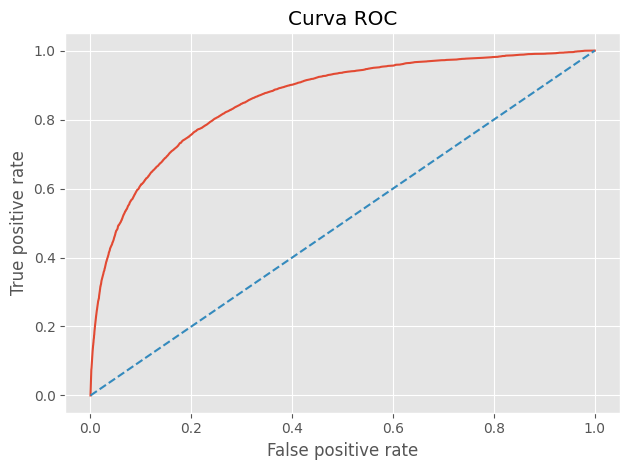

In [14]:
#PLOT CURVE ROC
Metrics().plot_roc_curve(y_test, y_prob)

In [38]:
#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.33, stratify=y_over,random_state=42)

#IMPORTACION DE LIBRERIA
from sklearn.ensemble import RandomForestClassifier

#INSTANCIA Y ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier( bootstrap=True,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_leaf=4,
                                min_samples_split=5,
                                n_estimators=200,
                                random_state=42)
model.fit(X_train, y_train)

#PREDICCION
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8298


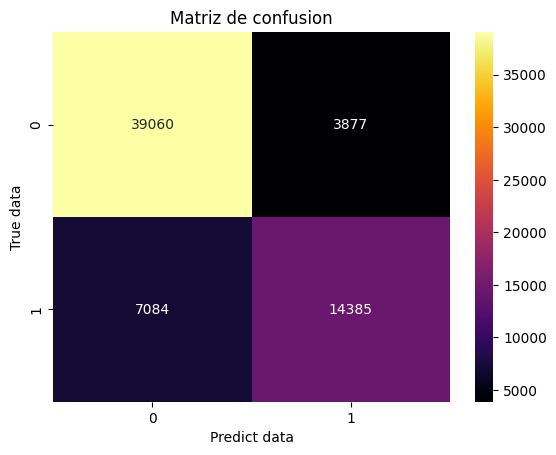

In [39]:
#GRAFICO DE MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [40]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     42937
           1       0.79      0.67      0.72     21469

    accuracy                           0.83     64406
   macro avg       0.82      0.79      0.80     64406
weighted avg       0.83      0.83      0.83     64406



In [41]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8911


### XG-Boost - Entrenamiento y validacion simple del modelo

In [146]:
#IMPOTRACION DE MODELO PARA TEST DE PARAMETROS
from sklearn.model_selection import GridSearchCV

#GRILLA DE PARAMETROS PARA TESTEAR
param_grid = {
    'objective' :['binary:logistic'],
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [9, 15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.1, 0.2],
    'random_state': [47]
}

In [42]:
#IMPORTACION MODELO DE BOOOSTING
from xgboost import XGBClassifier

#SE ENTRENA MODELO UTILIZANDO GRIDSEARCH
#model = GridSearchCV(estimator=XGBClassifier(),
#                     param_grid=param_grid,
#                     cv=3, n_jobs=-1,
#                     scoring='accuracy')

#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x_under, y_under, test_size=0.33, stratify=y_under,random_state=42)

model = XGBClassifier( objective = 'binary:logistic',
                       max_depth = 10,
                       learning_rate = 0.2,
                       n_estimators = 15,
                       subsample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0.2,
                       random_state = 47)

#ENTRENAMIENTO
model.fit(X_train,y_train)

#PREDICCION
y_pred = model.predict(X_test)

#SCORE
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8308


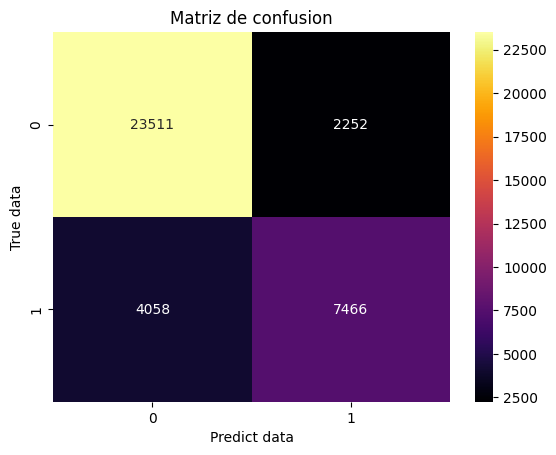

In [43]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [44]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     25763
           1       0.77      0.65      0.70     11524

    accuracy                           0.83     37287
   macro avg       0.81      0.78      0.79     37287
weighted avg       0.83      0.83      0.83     37287



In [45]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8827


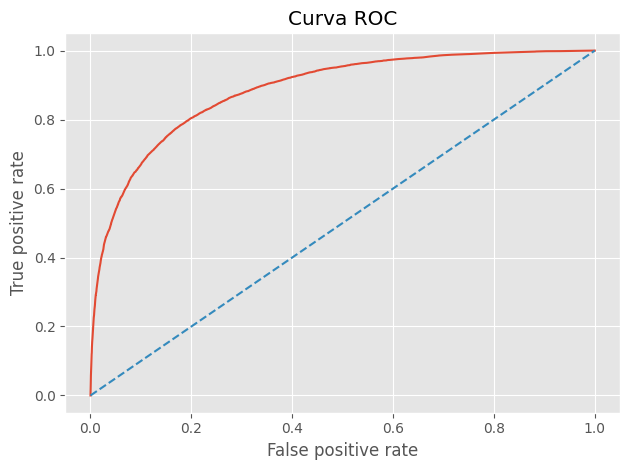

In [45]:
#PLOT CURVE ROC
Metrics().plot_roc_curve(y_test, y_prob)

In [46]:
#DIVISION DE DATOS PARA TRAIN Y TEST
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.33, stratify=y_over,random_state=42)

model = XGBClassifier( objective = 'binary:logistic',
                       max_depth = 10,
                       learning_rate = 0.2,
                       n_estimators = 15,
                       subsample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0.2,
                       random_state = 47)

#ENTRENAMIENTO
model.fit(X_train,y_train)

#PREDICCION
y_pred = model.predict(X_test)

#SCORE
accuracy = accuracy_score(y_true=y_test ,y_pred=y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8321


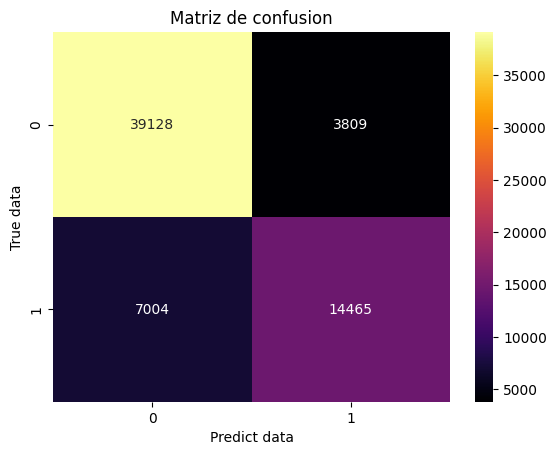

In [47]:
#GRAFICO MATRIZ DE CONFUSION
Metrics().plot_confusion_matrix_dicotomic(y_test, y_pred, None, None)

In [48]:
#REPORTE
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     42937
           1       0.79      0.67      0.73     21469

    accuracy                           0.83     64406
   macro avg       0.82      0.79      0.80     64406
weighted avg       0.83      0.83      0.83     64406



In [49]:
#SCORE CURVA ROC
y_prob = model.predict_proba(X_test)[:,1]
print(f'Score curva ROC: {roc_auc_score(y_test, y_prob):.4f}')

Score curva ROC: 0.8935


model = GridSearchCV(DecisionTreeClassifier(),
                     param_grid=param_grid,
                     cv=3,
                     n_jobs=-1,
                     scoring='accuracy')

model.fit(X_train, y_train)

print(f'Mejor puntaje de validacion cruzada(en entrenamiento): {model.best_score_}')
print('\nMejores parametros:')
for key, value in model.best_params_.items():
    print(f'\t{key}: {value}')

### Prediccion

In [21]:
df_test = pd.read_csv('test.csv')

In [22]:
#TRANSFORMACION VARIABLE GENDER
df_test.loc[df_test.Gender == 'Female', 'Gender'] = '0'
df_test.loc[df_test.Gender == 'Male', 'Gender'] = '1'
df_test.Gender = df_test.Gender.astype(int)
df_test.Gender.value_counts()

#TRANSFORMACION DE VARIABLES CATEGORICAS
dummies = pd.get_dummies(df_test['Geography'], dtype=int)
dummies.head()

#LISTA DE VARIABLES A NORMALIZAR
vars = ['Age','Balance']

#INSTANCIA DEL MODELO Y TRANSOFRMACION
std_vars = StandardScaler().fit_transform(df_test[vars])

#SE CREA DATAFRAME COMPLEMETARIO
std_vars = pd.DataFrame(std_vars, columns=vars)

#SELECCION DE VARIABLES
vars = ['NumOfProducts','IsActiveMember','Gender']

#VARIABLES PREDICTIVAS
x = pd.concat([df_test[vars],
                std_vars,
                dummies], axis=1)

#PREDICCION
y_pred = model.predict(x)

In [23]:
#CONCATENACION DE ARCHIVO PARA EXPORTAR
y_pred = pd.Series(y_pred, name='Exited')
sample_submission = pd.concat([df_test.id, y_pred], axis=1)

In [24]:
#sample_submission.to_csv('submission.csv', index=False)

In [25]:
sample_submission.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,1
